All E network, E cells from Christoph's model  
E-E using NMDA channel in book.
Weight change follows

In [18]:
from brian2 import *
#import numpy as np
#import matplotlib
import matplotlib.pyplot as plt

In [19]:
start_scope()

defaultclock.dt = 0.02*ms

Ne = 8

Cm = 1*ufarad/cm**2
El = -67*mV
ENa = 50*mV
EK = -100*mV
gl = 0.1*msiemens/cm**2
gNa = 100*msiemens/cm**2
gK = 80*msiemens/cm**2
V_I = -80*mV
V_E = 0*mV

# STDP vars
gmax = 1.0/Ne *msiemens/cm**2
# gampa0 = 0.01/Ne *msiemens/cm**2
gampa0 = 0.0/Ne *msiemens/cm**2


# NMDA (excitatory)
g_NMDA_E = 1.0/(Ne-1)*msiemens/cm**2
# g_NMDA_I = 0.258 * nS * 800. / N_E
tausnmdar = 1*ms
tausnmdad = 100*ms
# alpha = 0.5 / ms
Mg2 = 1.

# some calcium-related vars, table 2
pHC = 4*umolar
aHC = 0.6*umolar
pHN = 4.
aHN = 3.
alphav = 1.
alphab = 5.
alphad = 1.
thetav = 2.*umolar
thetad = 2.6*umolar
thetab = 0.55*umolar
Cp = 5.
Cd = 4.
taup = 500*ms
taua = 5*ms
tauv = 10*ms
taud = 250*ms
taub = 40*ms
sigmav = -0.05*umolar
sigmad = -0.01*umolar
sigmab = -0.02*umolar
p = 0.3
d = 0.01
kd = -0.002
kp = -0.1

# some calcium-related vars, concentration
phi = 0.01
beta = 0.083/ms
chi0 = 0.05*umolar
nbuff = 6.




eqs = '''
dv/dt = ( (gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v) + Isyn + I_NMDA_rec + I))/Cm : volt
Isyn = Iampa : amp*meter**-2
Iampa = gampa * (V_E - v) * sampa_tot : amp*meter**-2
sampa_tot : 1
gampa : siemens/meter**2
I_NMDA_rec = -g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp*meter**-2
s_NMDA_tot : 1
I : amp*meter**-2
m = alpham / (alpham + betam) :1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.32/mV) * (v+54*mV) / (-exp((-v-54*mV) / (4*mV)) + 1)/ms : Hz
betam = (0.28/mV) * (v+27*mV)/ (exp((v+27*mV)/(5*mV)) - 1)/ms : Hz
alphah = (0.128) * exp(-(v+50*mV)/(18*mV))/ms : Hz
betah = 4/(exp((-v-27*mV) / (5*mV)) + 1)/ms : Hz
alphan = (0.032/mV) * (v+52*mV) / (-exp(-(v+52*mV) / (5*mV)) + 1)/ms : Hz
betan = 0.5*exp(-(v+57*mV)/(40*mV))/ms : Hz

#chi : mmolar
dchi/dt = phi*I_NMDA_rec/(uA/cm**2)*mmolar/ms - beta*(chi-chi0) -(beta/nbuff)*chi**2/mmolar : mmolar
dP/dt = ((10*(chi/pHC)**pHN / (1+(chi/pHC)**pHN))-Cp*A*P)/taup : 1
dA/dt = (((chi/aHC)**aHN/(1+(chi/aHC)**aHN))-A)/taua : 1
dV/dt = ( alphav/(1+exp((chi-thetav)/sigmav)) -V)/tauv : 1
dB/dt = ( alphab/(1+exp((chi-thetab)/sigmab)) -B-Cd*V*B)/taub : 1
dD/dt = ( alphad/(1+exp((chi-thetad)/sigmad)) -D)/taud : 1
'''

    

Ecells = NeuronGroup(Ne, eqs, threshold='v>0*mV',refractory='v > 0*mV',
                method='rk4')

# Initialization
Ecells.v = -60*mV
# Ecells.m = 0.
# Ecells.n = 0.
# Ecells.h = 0.
Ecells.P = 0.
Ecells.A = 0.
Ecells.V = 0.
Ecells.B = 0.
Ecells.D = 0.





# STDP gampa start from small value
Ecells.gampa = gampa0
# Ecells.I = np.random.uniform(0.2, 5,Ne)*amp*meter**-2
Ecells.I = linspace(0.1,5,(Ne))*amp*meter**-2
Ecells.chi = 0.06*umolar
#Ecells.I = [0.1,1.0,(Ne-1)]*amp*meter**-2
Me = StateMonitor(Ecells, 'v', record=[0,1])
# Synapses
alphaw = 0.8
betaw = 0.6
tauw = 500*ms


eqs_nmda  = ''' 
#w : 1 # synaptic weight
s_NMDA_tot_post = w * s_NMDA : 1 (summed)
ds_NMDA / dt = (1+tanh(v_pre/mV/10))/2 * (1-s_NMDA)/tausnmdar - s_NMDA/tausnmdad : 1 (clock-driven)
dw/dt = ( alphaw/(1+exp((P-p)/kp)) - betaw/(1+exp((D-d)/kd)) - w )/tauw :1 (clock-driven)
'''

C_STDP = Synapses(Ecells, Ecells, model=eqs_nmda, 
                 method='rk4')
# # C_E_I = Synapses(Ecells, Icells, model=eqs_ampa, method='rk4')
C_STDP.connect(condition='i != j')
C_STDP.w[:] = 1


# mon = StateMonitor(C_STDP, 'w',record = True)
#mon = StateMonitor(C_E_E, 'sampa_tot',record = True)
mon_v = StateMonitor(Ecells, 'v',record = [0,1,2])

# sp_E = SpikeMonitor(Ecells,variables='v')
# sp_I = SpikeMonitor(Icells,variables='v')

WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 99999. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [20]:
mon = StateMonitor(C_STDP, 'w',record = True)


run(2000*ms,report='stdout')


Starting simulation at t=0. s for a duration of 2. s
1.02482 (51%) simulated in 10s, estimated 10s remaining.
1.80228 (90%) simulated in 20s, estimated 2s remaining.
2.0 (100%) simulated in 22s


In [4]:
test_w =np.transpose(mon.w)

test_w.shape

(100000, 56)

In [5]:
test_diff  = [0]*150000;

for t_i in range(0,150000):
#     plot(t_i,amax(test_w[t_i]) - amin(test_w[t_i]),'.')

    test_diff[t_i]=amax(test_w[t_i]) - amin(test_w[t_i]);


# amax(test_w) - amin(test_w)


(10, 20)

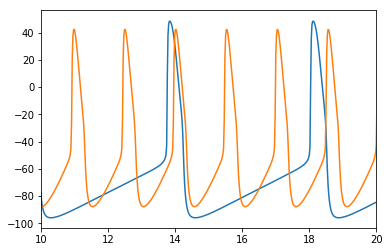

In [23]:

plot(Me.t/ms,Me[0].v/mV)

plot(Me.t/ms,Me[1].v/mV)
# plot(Me.t/ms,Me[2].v/mV)


plt.xlim(10,20)
# plt.xlim(5,15)


# Me.v.shape

In [121]:
Ecells.I

<neurongroup_1.I: array([0., 0., 0., 0., 0.]) * amp * meter ** -2>

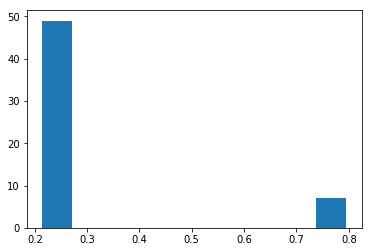

In [29]:
i = 99999
n, bins, patches = plt.hist(test_w[i][:])
plt.show()

In [138]:
test_w[140499]

array([0.20282554, 0.79660641])

Text(0,0.5,'w')

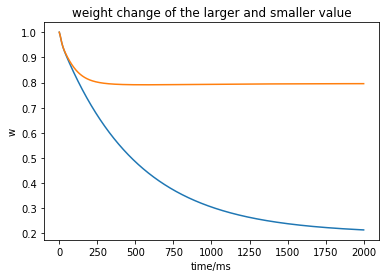

In [30]:
plot(mon.t/ms,mon.w[1])
plot(mon.t/ms,mon.w[0])

title('weight change of the larger and smaller value')
xlabel('time/ms')
ylabel('w')

In [34]:
linspace(0.1,5,(Ne))

array([0.1, 0.8, 1.5, 2.2, 2.9, 3.6, 4.3, 5. ])

In [142]:

t_i = 149000
amax(test_w[t_i]) - amin(test_w[t_i])

0.5944165539199735

In [146]:
test_diff_2 = diff(test_diff)

Text(0.5,1,'diff of strength diff')

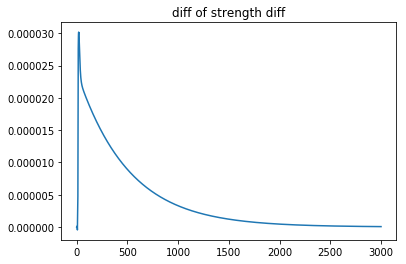

In [155]:
plot(mon.t[1:]/ms,test_diff_2)
title('diff of strength diff')

Text(0.5,1,'Synaptic weight')

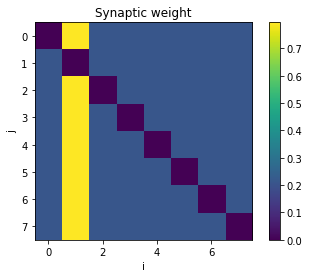

In [5]:
i=99999

w_test = np.zeros((Ne,Ne))
w_test[C_STDP.i[:],C_STDP.j[:]]=test_w[i][:]
imshow(w_test)
colorbar()
xlabel('i')
ylabel('j')
title('Synaptic weight')

In [51]:
test_w[i][:].shape

(56,)

In [55]:
C_STDP.j[:]

array([1, 2, 3, 4, 5, 6, 7, 0, 2, 3, 4, 5, 6, 7, 0, 1, 3, 4, 5, 6, 7, 0,
       1, 2, 4, 5, 6, 7, 0, 1, 2, 3, 5, 6, 7, 0, 1, 2, 3, 4, 6, 7, 0, 1,
       2, 3, 4, 5, 7, 0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [42]:
C_STDP.i[:]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7], dtype=int32)

In [17]:
j=0
for j in range (56):
    print(j,end=' ')
i=99999


print('\n')
print(C_STDP.i[:])
print(C_STDP.j[:])
print(test_w[i][:])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 7 7 7]
[1 2 3 4 5 6 7 0 2 3 4 5 6 7 0 1 3 4 5 6 7 0 1 2 4 5 6 7 0 1 2 3 5 6 7 0 1
 2 3 4 6 7 0 1 2 3 4 5 7 0 1 2 3 4 5 6]
[0.79550078 0.21373528 0.21419334 0.21419683 0.21419817 0.21419873
 0.21419875 0.21380042 0.21373528 0.21419334 0.21419683 0.21419817
 0.21419873 0.21419875 0.21380042 0.79550078 0.21419334 0.21419683
 0.21419817 0.21419873 0.21419875 0.21380042 0.79550078 0.21373528
 0.21419683 0.21419817 0.21419873 0.21419875 0.21380042 0.79550078
 0.21373528 0.21419334 0.21419817 0.21419873 0.21419875 0.21380042
 0.79550078 0.21373528 0.21419334 0.21419683 0.21419873 0.21419875
 0.21380042 0.79550078 0.21373528 0.21419334 0.21419683 0.21419817
 0.21419875 0.21380042 0.79550078 0.21373528 0.21419334 0.21419683
 0.2141

In [47]:
w_test.shape

(8, 8)

In [49]:
dx, dy = 0.15, 0.05

y, x = np.mgrid[slice(-3, 3 + dy, dy),
                slice(-3, 3 + dx, dx)]

In [59]:
phi_m = linspace(0, 2*pi, 100)
phi_p = linspace(0, 2*pi, 100)
X,Y = meshgrid(phi_p, phi_m)